In [1]:
from ema_workbench import (Model, Constant, RealParameter, Policy, Scenario, ScalarOutcome)
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import (MultiprocessingEvaluator, ema_logging, perform_experiments) # parallel computing

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

ema_logging.log_to_stderr(ema_logging.INFO)

'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''

dike_model, planning_steps = get_model_for_problem_formulation(2) # assign problem_formulation_id

dike_model.constants =[Constant('A.1_DikeIncrease 0', 0),
                       Constant('A.1_DikeIncrease 1', 0),
                       Constant('A.1_DikeIncrease 2', 0),
                       Constant('A.2_DikeIncrease 0', 0),
                       Constant('A.2_DikeIncrease 1', 0),
                       Constant('A.2_DikeIncrease 2', 0),
                       Constant('A.3_DikeIncrease 0', 0),
                       Constant('A.3_DikeIncrease 1', 0),
                       Constant('A.3_DikeIncrease 2', 0),
                       Constant('A.4_DikeIncrease 0', 0),
                       Constant('A.4_DikeIncrease 1', 0),
                       Constant('A.4_DikeIncrease 2', 0),
                       Constant('A.5_DikeIncrease 0', 0),
                       Constant('A.5_DikeIncrease 1', 0),
                       Constant('A.5_DikeIncrease 2', 0)]

C:\Users\georg\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
# for levers in dike_model.levers:
    print(levers)

IndentationError: unexpected indent (<ipython-input-2-ff2a104e237a>, line 2)

## Find the number of scenarios needed in order the robustness metrics to converge
### It will be explored based on the convergence of 6 random policies over a number of scenarios 


In [ ]:
import functools

percentile10 = functools.partial(np.percentile, q=10)
percentile90 = functools.partial(np.percentile, q=90)

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE 
robustness_functions = [ScalarOutcome('Expected Annual Damage', kind=MINIMIZE,
                             variable_name='Expected Annual Damage', function=percentile90),
                       ScalarOutcome('Total Investment Costs', kind=MINIMIZE,
                             variable_name='Total Investment Costs', function=percentile90),
#                        ScalarOutcome('RfR Investment Costs', kind=MINIMIZE,
#                              variable_name='max_P', function=percentile90),
#                        ScalarOutcome('Evacuation Costs', kind=MINIMIZE,
#                              variable_name='max_P', function=percentile90),
                       ScalarOutcome('Expected Number of Deaths', kind=MINIMIZE,
                             variable_name='Expected Number of Deaths', function=percentile90)]

In [5]:
%%time 
from ema_workbench import ema_logging, MultiprocessingEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=25,               
                                            policies=14)
    

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 25 scenarios * 14 policies * 1 model(s) = 350 experiments
[MainProcess/INFO] 35 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 105 cases completed
[MainProcess/INFO] 140 cases completed
[MainProcess/INFO] 175 cases completed
[MainProcess/INFO] 210 cases completed
[MainProcess/INFO] 245 cases completed
[MainProcess/INFO] 280 cases completed
[MainProcess/INFO] 315 cases completed
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Wall time: 2min 24s


In [6]:
results

(     A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
 0                        7.0  136.464344         1   0.207173  143.409824   
 1                       95.0  236.055364         1   0.434425  112.583272   
 2                      112.0  268.055062        10   0.248578  263.462558   
 3                       27.0  101.369708         1   0.645319  101.229308   
 4                      101.0  168.529764       1.5   0.936465  175.533691   
 5                       39.0  294.699907        10   0.549914  302.406880   
 6                       66.0   54.659927         1   0.296943  120.370616   
 7                       45.0  185.293337        10   0.835447  255.874155   
 8                       76.0  228.108897         1   0.375277   82.964819   
 9                       59.0   78.203896         1   0.446816   80.158257   
 10                      74.0   39.428421       1.5   0.694076  236.993990   
 11                      89.0  255.911480        10   0.968724  

In [59]:
save_results(results, "OptimizationMoro250scen6pol.tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\georg\OneDrive\Documents\GitHub\MBDM-group-11\final assignment\OptimizationMoro250scen6pol.tar.gz


In [13]:
results = load_results(".\OptimizationMoro250scen6pol.tar.gz")
experiments, outcomes = results

### Visualize the evolution of the chosen convergence metric

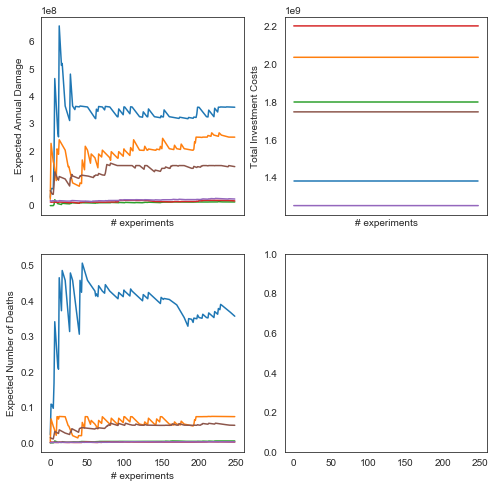

In [12]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8),
                        sharex=True)
axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]                             #axes[1,1]

for ax, (outcome, value) in zip(axes, outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]
        
        robustness = []
      
        for i in range(1, data.shape[0]):
            robustness.append(percentile90(data[0:i]))
        ax.plot(robustness, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)

In [ ]:
### Now for each outcome we have N scenarios so in order to have one value for each policy we take the 90th percentile

In [32]:
Expected_Number_of_Deaths = functools.partial(np.percentile, q=90)
Expected_Annual_Damage = functools.partial(np.percentile, q=90)
Total_Investment_Costs = functools.partial(np.percentile, q=90)

In [71]:
#experiments['policy']

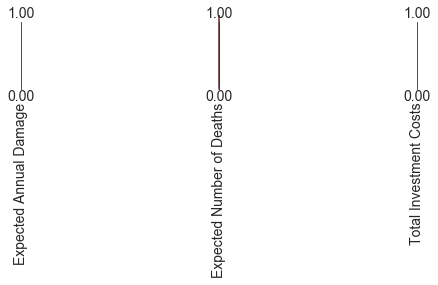

In [39]:
import pandas as pd

from ema_workbench.analysis import parcoords

# just a dictionary giving names to different functions
funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

total_scores = {}    # just an empty dict

for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy'] == policy
    temp_outcomes = {k:v[logical] for k,v in outcomes.items()} #create dictionary and picks only the data from a specific policy
    
    
    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data = pd.DataFrame(total_scores).T.reset_index(drop=True)
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [50]:
data

,Expected Annual Damage,Expected Number of Deaths,Total Investment Costs
0,3.598543e+08,0.354952,1.384073e+09
1,2.504351e+08,0.073797,2.034537e+09
2,1.330254e+07,0.005162,1.800492e+09
3,1.712113e+07,0.002193,2.199941e+09
4,2.399989e+07,0.002710,1.252844e+09
5,1.421084e+08,0.049355,1.746862e+09


In [33]:
temp_outcomes

{'Expected Annual Damage': array([5.46267381e+07, 5.58410020e+06, 4.57339748e+06, 1.06601025e+07,
        2.19368156e+07, 9.73700995e+07, 1.62370789e+08, 9.29425464e+06,
        6.33704415e+06, 0.00000000e+00, 4.70797205e+07, 1.71107508e+06,
        1.08671603e+08, 4.58287894e+07, 4.10638791e+07, 2.75662477e+07,
        4.30959871e+07, 6.99026946e+06, 2.09344378e+06, 4.34546892e+07,
        8.73261018e+06, 5.37317272e+06, 2.14087145e+07, 3.38280701e+06,
        2.59514531e+06, 1.26120934e+07, 2.10199352e+06, 1.05648034e+09,
        5.02394339e+07, 2.51942030e+08, 5.59439606e+07, 6.76147519e+07,
        0.00000000e+00, 9.31961212e+06, 4.45986466e+07, 6.46532048e+06,
        8.82389408e+05, 1.70177145e+07, 5.37043837e+06, 1.01100351e+08,
        1.12258635e+08, 5.46121996e+07, 1.46543746e+08, 4.01796512e+07,
        6.57246247e+06, 1.43889160e+07, 1.61149266e+07, 7.03886024e+06,
        0.00000000e+00, 4.65203999e+06, 1.31720679e+07, 7.26283881e+06,
        1.37539957e+07, 5.19866723e+07

In [ ]:
from ema_workbench.em_framework import sample_uncertainties

n_scenarios = 75
scenarios = sample_uncertainties(dike_model, n_scenarios)

In [4]:
nfe = 50

epsilon = [1e2, 1e2, 1]

convergence_metrics = [HyperVolume(minimum=[0,0,0], maximum=[5e6, 2e9, 1]),
                       EpsilonProgress()]


In [75]:
%%time 
with MultiprocessingEvaluator(dike_model) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustnes_functions, scenarios,
                            nfe=nfe, convergence=convergence_metrics, epsilons=epsilon)


[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/50 nfe
[MainProcess/INFO] optimization completed, found 8 solutions
[MainProcess/INFO] terminating pool


Wall time: 52min 21s


In [76]:
robust_results.to_csv("OptimizationMoro75scen50nfe")

In [77]:
import pandas as pd
rrr = pd.read_csv("OptimizationMoro75scen50nfe", index_col=0)

NameError: name 'convergence' is not defined

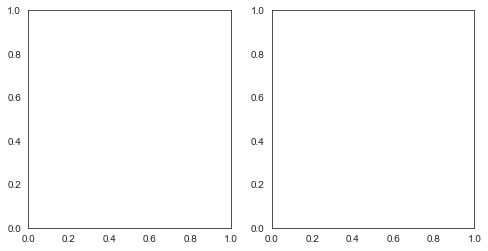

In [74]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()